# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** dataset. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

First off, I'll implement my own feedforward network for the exercise you worked on in part 4 using the Fashion-MNIST dataset. This will serve as a solution for part 4, as well as an example of how to use dropout and validation.

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

In [8]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Building the network

As with MNIST, each image in Fashion-MNIST is 28x28 which is a total of 784 pixels, and there are 10 classes. I used `nn.ModuleList` to allow for an arbitrary number of hidden layers. This model has an argument `hidden_layers` that's a list of the hidden layer sizes (as integers). Using `nn.ModuleList` registers each hidden layer module properly so you can use module methods in the model.

I also have the `forward` method returning the log-softmax for the output. Since softmax is a probability distibution over the classes, the log-softmax is a log probability which comes with a [lot of benefits](https://en.wikipedia.org/wiki/Log_probability). Using the log probability, computations are often faster and more accurate. To get the class probabilities later, I'll need to take the exponential (`torch.exp`) of the output.

We can include dropout in our network with [`nn.Dropout`](http://pytorch.org/docs/master/nn.html#dropout). This works similar to other modules such as `nn.Linear`. It also takes the dropout probability as an input which we can pass as an input to the network.

In [9]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

# Train the network

Since the model's forward method returns the log-softmax, I used the [negative log loss](http://pytorch.org/docs/master/nn.html#nllloss) as my criterion, `nn.NLLLoss()`. I also chose to use the [Adam optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Adam). This is a variant of stochastic gradient descent which includes momentum and in general trains faster than your basic SGD.

I've also included a block to measure the validation loss and accuracy. Since I'm using dropout in the network, I need to turn it off during inference. Otherwise, the network will appear to perform poorly because many of the connections are turned off. PyTorch allows you to set a model in "training" or "evaluation" modes with `model.train()` and `model.eval()`, respectively. In training mode, dropout is turned on, while in evaluation mode, dropout is turned off. This effects other modules as well that should be on during training but off during inference.

The validation code consists of a forward pass through the validation set (also split into batches). With the log-softmax output, I calculate the loss on the validation set, as well as the prediction accuracy.

In [10]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [500], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    # Model in training mode, dropout is on
    model.train()
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = model.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  # Replaced '.data[0]' to avoid warning
        
        if steps % print_every == 0:
            # Model in inference mode, dropout is off
            model.eval()
            
            accuracy = 0
            test_loss = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                
                '''
                tzo, 04/30/18:
                Replaced this with code below since volatile flag is
                no longer supported in PyTorch 0.4
                
                # Set volatile to True so we don't save the history
                inputs = Variable(images, volatile=True)
                labels = Variable(labels, volatile=True)
                '''
                
                # Locally disable gradient
                with torch.no_grad():
                    inputs = Variable(images)
                    labels = Variable(labels)

                output = model.forward(inputs)
                test_loss += criterion(output, labels).item() # Replaced '.data[0]' to avoid warning
                
                ## Calculating the accuracy 
                # Model's output is log-softmax, take exponential to get the probabilities
                ps = torch.exp(output).data
                # Class with highest probability is our predicted class, compare with true label
                equality = (labels.data == ps.max(1)[1])
                # Accuracy is number of correct predictions divided by all predictions, just take the mean
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure dropout is on for training
            model.train()

Epoch: 1/2..  Training Loss: 1.028..  Test Loss: 0.724..  Test Accuracy: 0.721
Epoch: 1/2..  Training Loss: 0.730..  Test Loss: 0.610..  Test Accuracy: 0.777
Epoch: 1/2..  Training Loss: 0.653..  Test Loss: 0.580..  Test Accuracy: 0.785
Epoch: 1/2..  Training Loss: 0.604..  Test Loss: 0.553..  Test Accuracy: 0.787
Epoch: 1/2..  Training Loss: 0.578..  Test Loss: 0.551..  Test Accuracy: 0.793
Epoch: 1/2..  Training Loss: 0.573..  Test Loss: 0.519..  Test Accuracy: 0.809
Epoch: 1/2..  Training Loss: 0.504..  Test Loss: 0.533..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.572..  Test Loss: 0.500..  Test Accuracy: 0.816
Epoch: 1/2..  Training Loss: 0.496..  Test Loss: 0.516..  Test Accuracy: 0.806
Epoch: 1/2..  Training Loss: 0.506..  Test Loss: 0.487..  Test Accuracy: 0.822
Epoch: 1/2..  Training Loss: 0.537..  Test Loss: 0.508..  Test Accuracy: 0.812
Epoch: 1/2..  Training Loss: 0.514..  Test Loss: 0.472..  Test Accuracy: 0.827
Epoch: 1/2..  Training Loss: 0.538..  Test Loss: 0.4

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`.

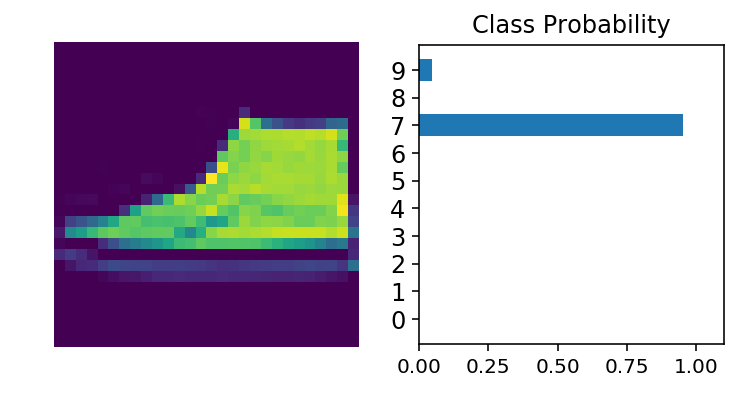

In [21]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
with torch.no_grad():  # Locally disable gradient because not needed here
    img = Variable(img.resize_(1, 784))

# Calculate the class probabilities (softmax) for img
output = model.forward(img)
ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.